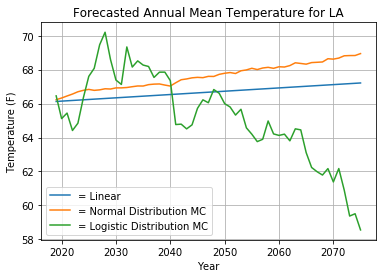

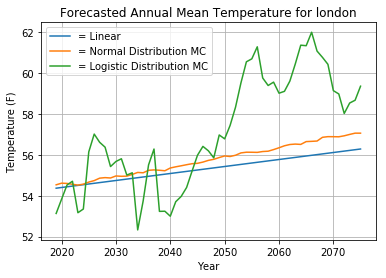

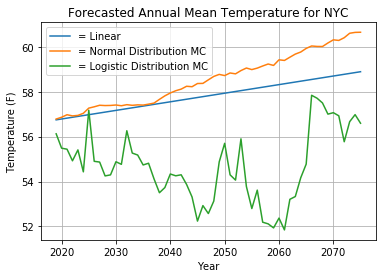

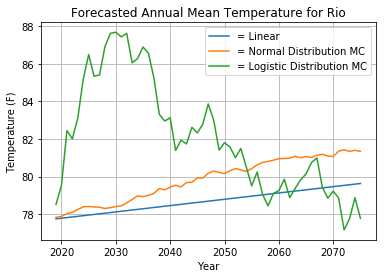

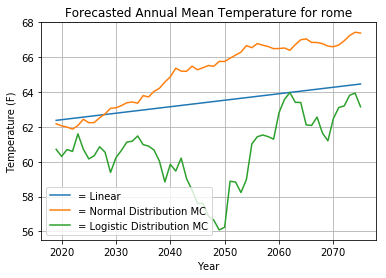

[['71.0' '0\n']
 ['75.8' '0\n']
 ['77.1' '0\n']
 ...
 ['97.1' '0\n']
 ['92.8' '0\n']
 ['94.7' '0\n']]


TypeError: cannot perform reduce with flexible type

In [4]:
import numpy as np 
import math
from scipy import stats
import matplotlib.pyplot as plt


#for group 1 cities: 


#parameter(s): city name
#purpose: open csv file and read data onto a list
def extract_data(city_name):
    city = open(city_name, 'r') #open file

    data_list = [] #init list for city 
    for line in city: #read in each line into list w/ comma as delimiter
        data_list.append(line.split(","))
    
    city.close() #close the file:
    
    header=data_list.pop(0)
    return data_list


def g2_extract(city_name):
    data = np.loadtxt(city_name, delimiter=",", skiprows=1,usecols=[2])
    return data


#parameter(s): city data list
#purpose: convert list from string to floats
def str_to_floats(city_list):
    
    for row in city_list:
        #3 columns for 3 variables, use loop to iterate through each row and change each value into a float
        for y in range(0,5):
            #if data is present aka able to convert to float do it, else put None for value
            try:
                row[y] = float(row[y])
            except ValueError:
                row[y] = None
    return city_list


#parameter(s): float list
#purpose: calc daily mean in same list
def dailyx(city_float):  

    for index, row in enumerate(city_float):
        del city_float[index][0]
        del city_float[index][3]
        del city_float[index][3]

    #all() returns true all elements per row are iterable aka no missing data and stores this into a new temp list
    dailyx_list = [r for r in city_float if all(x for x in r)]
    
    #get mean of daily  max and min temp and temp at observation 
    for index1, row1 in enumerate(dailyx_list):
        #gets daily mean temperature and stores into column 0 per daily index
        dailyx_list[index1][0]=((dailyx_list[index1][0]+dailyx_list[index1][1]+dailyx_list[index1][2])/3)
        #delete 2 remaining columns
        del dailyx_list[index1][1]
        del dailyx_list[index1][1]
        
    return dailyx_list

def dailyx_G2_custom(city_float):  

    for index, row in enumerate(city_float):
        del city_float[index][0]
        del city_float[index][0]
        del city_float[index][1]
        del city_float[index][1]

    #all() returns true all elements per row are iterable aka no missing data and stores this into a new temp list
    dailyx_list = [r for r in city_float if all(x for x in r)]
        
    return dailyx_list


#parameter(s): daily mean float list
#purpose: conver to numpy arr
def list2numpy(daily_mean):

    #convert data from list to numpy array
    np_array = np.asarray(daily_mean)
    return np_array

#parameter(s): numpy daily mean array
#purpose: calc every 2,4,8 yr weighted means, temp difference, and first std dev for simulation use
def get_simul_stats(city_array):
    #2 yrs mean
    x=730
    #get sample size 
    ending = math.floor((city_array.size/730))
    #print (ending)

    #do array size * ending, get the difference of arr size - ending, use a second loop to calc the remaining mean 
    starting = 0
    temp_end = 730
    tally=1
    index=0
    maximum = 730*ending
    arr_stats = np.zeros((ending,2))   #use new numpy arr for calculations
    wma_sum = 0

    #get weighted mean per 2 yr period, then increment starting and ending index plus 2 yrs to get next 2yr weighted mean
    while (starting<maximum):
        wma_sum += ((np.mean(city_array[starting:temp_end]))*tally)    #to get weighted sum
        #arr_stats[index][0] = (((np.mean(city_array[starting:temp_end])))) #for normal mean over time period if wanted
        wma = ((wma_sum)/((tally*(tally+1))/2)) 
        arr_stats[index][0] = wma
        if (index>0):
            #difference in every 2yrs mean
            temp_diff = (arr_stats[index][0]-arr_stats[index-1][0])
            #if a temp dec, give it a 2/3 weight bc dec in temp less likely than inc in temp in future
            if (temp_diff > 0):

                arr_stats[index][1]= temp_diff 

            else:
                arr_stats[index][1] = temp_diff * 0.66
        else:
            arr_stats[0][1]= 0
        
        #increment starting and ending index +2yrs
        starting +=730
        temp_end +=730
        #loop counter
        tally +=1
        index +=1

    tally = tally-1 
    
    
    #for the leftover data in dataset, get its mean
    residual=ending-maximum
    
    #get dimensions of residual to ending, and get its mean
    last_x = (np.mean(city_array[residual:city_array.size]))

    fixed_std1=(((arr_stats.std(axis=0)) * tally) / (tally-1))
    
    starting_temp = np.mean(city_array[city_array.size-730:city_array.size])
    
    avg_inc_temp = arr_stats.mean(axis=0)
    
    doublestd = (fixed_std1[1])
#    print("2std/yr is: ", doublestd)
    
    final_stats = np.zeros((3,1))
    
    final_stats[0] = starting_temp
    final_stats[1] = avg_inc_temp[1]/2
    final_stats[2] = doublestd    
       
    return final_stats
# return new np arr with the 3 lin sim vars, send that arr to lin sim fx, and use same arr for my sim, too

    
#parameter(s): sim_stat fx data array
#purpose: stores annual new temp as a slope fx based on avg temp inc per yr 
def linear_simul(final_stats):       
    curr = 2019
    loop_count=0
    array_count=0
    a = np.zeros(shape=(57,2))
    
    
    while (curr <= 2075):     
        temp1 = (final_stats[0] + (final_stats[1]*(loop_count)))
        #print(curr, "year temp is:", temp1)
        a[array_count][0] = curr
        a[array_count][1] = temp1
        array_count +=1                  
        curr +=1
        loop_count +=1
    return a



#parameter(s): numpy stat array
#purpose: for monte carlo sim: use randn fx for normal + logisitic distribution for -1 to +2 std dev on annual yr to yr change
#...not doing more than 1 trial because then the data will become a normal distribution with the annual temp change...
#...converging to be the mean avg rate of change in yr to yr data from the get_sim_stats fx. 
def pseudo_monte_carlo (sim_stats):
    
    curr = 2019
    loop_count=0
    array_count=0
    b = np.zeros(shape=(57,3))
    
    
    while (curr <= 2075):   
        #here, loc is mean, and scale is 1 std dev, so use std dev / 2 for 1 std and loc = starting curr yr temp
        #using -1stdev to +2stdev since more likely temp inc than dec in future yr to yr change
        norm = stats.truncnorm.rvs(-1, 2, loc=sim_stats[1], scale=sim_stats[2]/2, size=1)
        #logistic distrubtion using alternative parameterization, where scale = q * stdev and q = root 3 / pi
        q = (math.sqrt(3) / math.pi)
        logistic_fig = np.random.logistic(loc=sim_stats[1], scale=q, size=None)
        logistic = np.mean(logistic_fig[0:logistic_fig.size])
                                                         
        #store curr yr in simulation in column 0
        b[loop_count][0] = curr  
        #store curr yr simulated temp from normal distr and logistic distr rand gen values in each column in array
        if (curr == 2019):
            b[loop_count][1] =  sim_stats[0] + norm 
            b[loop_count][2] =  sim_stats[0] + logistic
            

        else:
            b[loop_count][1] =  b[loop_count-1][1] + norm
            b[loop_count][2] =  b[loop_count-1][2] + logistic
            
        curr +=1
        loop_count +=1
    
    return b
    
    
#parameter(s): array from lin sim and pseudo sim, and city name from list
#purpose: plot each simulation line in one chart and label it. 
def sample_plot(lin_sim, pseudo_mc, city):
    %matplotlib inline
    x1 = lin_sim[:,0]
    y1 = lin_sim[:,1]
    x2 = pseudo_mc[:,0]
    y2 = pseudo_mc[:,1]
    x3 = pseudo_mc[:,0]
    y3 = pseudo_mc[:,2]
    
    plt.plot(x1,y1, x2, y2,x3,y3)
    plt.legend(['= Linear', '= Normal Distribution MC', '= Logistic Distribution MC'])
    plt.xlabel('Year')
    plt.ylabel('Temperature (F)')
    plt.title('Forecasted Annual Mean Temperature for %s' % (city) )
    plt.grid(True)
    plt.show()


def fx_control1(name):
    a=extract_data(i)
    b = str_to_floats(a)
    if (j == 'Kinshasa.csv' or 'Nairobi.csv'):
        c = dailyx_G2_custom(b)
    else:
        c = dailyx(b) 

    d = list2numpy(c)
    print (d)
    return d
    
group_one = ['LA.csv','london.csv','NYC.csv','Rio.csv','rome.csv']


for i in group_one:
    stored_data=extract_data(i)
    city_float = str_to_floats(stored_data)
    daily_mean = dailyx(city_float) 
    city_array = list2numpy(daily_mean)
    sim_stats = get_simul_stats(city_array)
    lin_sim = linear_simul(sim_stats)
    pseudo_mc = pseudo_monte_carlo(sim_stats)
    #other sim fx call here->
    sample_plot(lin_sim, pseudo_mc,i[:-4])

group_two = ['Karachi.csv', 'Kinshasa.csv', 'Nairobi.csv',  'Moscow.csv', 'New_Dehli.csv']

for j in group_two:
    if (j == 'Kinshasa.csv' or 'Nairobi.csv'):
        g2data = fx_control1(j)
        
        
    else:
        g2data = g2_extract(j)
        
    sim_stats2 = get_simul_stats(g2data)
    lin_sim2 = linear_simul(sim_stats2)
    pseudo_mc2 = pseudo_monte_carlo(sim_stats2)
    #other sim fx call here->
    sample_plot(lin_sim2, pseudo_mc2,j[:-4])



    
    #finalfx: take mean of all sim yr to yr temp and plot 